### 0. Importar librerías

In [1]:
import pandas as pd
import numpy as np

# Se define la semilla para que cuando se vuelva a ejecutar el split train-test
# los datos que contiene cada conjunto sean los mismos y para que la inicialización
# del modelo creado sea la misma.
semilla = 1234

---

# 1. Cargar el dataset

In [2]:
# Ruta del fichero
path = 'datos/datos_filtrados.csv'

# Cargar el dataset
datos = pd.read_csv(path)

# Al ser un dataset pequeño se muestra completo
datos

,AF365,AF450,35 deg,42 deg,Grupo
0,2.320158,1.229614,13.01,19.39,0
1,1.529274,0.616514,8.18,24.78,0
2,1.908257,0.955847,7.75,16.90,0
3,1.590625,1.018495,4.10,16.30,0
4,1.617071,1.242961,5.76,21.05,0
...,...,...,...,...,...
115,3.034884,2.051768,4.55,8.50,2
116,4.093525,3.037288,3.97,5.35,2
117,4.730000,3.040000,7.04,14.44,2
118,3.200000,2.360000,6.70,10.57,2


In [3]:
# Contar el número de instancias de cada grupo
datos['Grupo'].value_counts()

1    61
0    46
2    13
Name: Grupo, dtype: int64

## Preparar conjuntos de entrenamiento y test

In [4]:
# Se separa la variable a predecir (Grupo)
X = datos.drop('Grupo', axis=1)
y = datos['Grupo']

In [5]:
# Importar librería de scikit-learn para separar los datos
from sklearn.model_selection import train_test_split

# Separar datos en conjunto de entrenamiento (80%) y test (20%) de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=semilla)

In [6]:
# Visualizar la dimensión de los datos separados
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (96, 4)
Training Labels Shape: (96,)
Testing Features Shape: (24, 4)
Testing Labels Shape: (24,)


In [7]:
# Distribución de los grupos en el conjunto de entrenamiento
y_train.value_counts()

1    49
0    37
2    10
Name: Grupo, dtype: int64

In [8]:
# Valores normalizados
y_train.value_counts(normalize=True)

1    0.510417
0    0.385417
2    0.104167
Name: Grupo, dtype: float64

In [9]:
# Distribución de los grupos en el conjunto de test
y_test.value_counts()

1    12
0     9
2     3
Name: Grupo, dtype: int64

In [10]:
# Valores normalizados
y_test.value_counts(normalize=True)

1    0.500
0    0.375
2    0.125
Name: Grupo, dtype: float64

### Visualizar distribución de cada conjunto (entrenamiento y test)

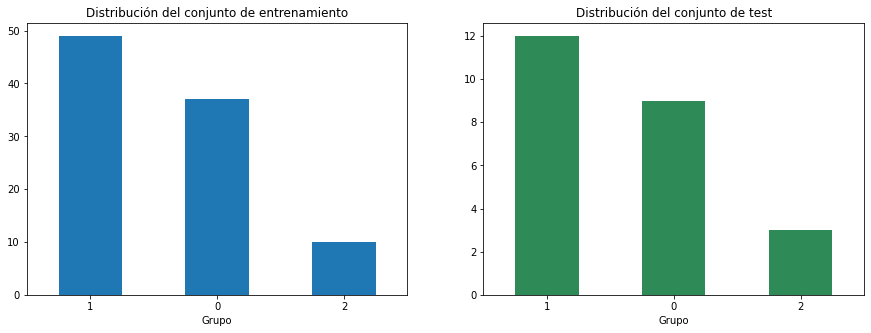

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

#fig.suptitle("Distribución de los grupos en los conjuntos de entrenamiento y test")

# Representación del conjunto de entrenamiento
plt.subplot(121)
y_train.value_counts().plot(kind='bar')
plt.title('Distribución del conjunto de entrenamiento')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

# Representación del conjunto de test
plt.subplot(122)
y_test.value_counts().plot(kind='bar', color='seagreen')
plt.title('Distribución del conjunto de test')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

plt.show()

### Escalar los datos

Información sobre esto: https://datascience.stackexchange.com/questions/78489/feature-scaling-for-mlp-neural-network-sklearn

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# El escalado se ajusta con la media y la desviación estandar del conjunto de entrenamiento
scaler.fit(X_train)

StandardScaler()

In [13]:
# Se aplica la transformación a los datos
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

---

# 2. Crear el modelo

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definición del modelo
modelo = MLPClassifier(random_state=semilla)

# Definición de parámetros de búsqueda
parametros = {'hidden_layer_sizes': [(8,8), (16,8), (32,16)],
              'activation'        : ['logistic','tanh','relu'],
              'solver'            : ['sgd','adam'],
              'alpha'             : 10.0 ** -np.arange(1, 10),
              'learning_rate'     : ['constant'],
              'learning_rate_init': [0.001],
              'max_iter'          : [1000,1500,2000],
              'verbose'           : [False],
              'early_stopping'    : [True,False],
              'n_iter_no_change'  : [10]}

# Definición de los folds estratificados
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=semilla)

# Búsqueda de parámetros
grid = GridSearchCV(
    estimator  = modelo,
    param_grid = parametros,
    scoring    = 'accuracy',
    n_jobs     = -1,
    cv         = folds,
    verbose    = 0,
    return_train_score = True
    )

# Entrenamiento
grid.fit(X_train_norm, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=1234, shuffle=True),
             estimator=MLPClassifier(random_state=1234), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(8, 8), (16, 8), (32, 16)],
                         'learning_rate': ['constant'],
                         'learning_rate_init': [0.001],
                         'max_iter': [1000, 1500, 2000],
                         'n_iter_no_change': [10], 'solver': ['sgd', 'adam'],
                         'verbose': [False]},
             return_train_score=True, scoring='accuracy')

In [15]:
# Visualización de los resultados de la búsqueda
df_resultados = pd.DataFrame(grid.cv_results_)
df_resultados = df_resultados.sort_values(by=['rank_test_score'])
df_resultados[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']].head()

,params,rank_test_score,mean_test_score,std_test_score
502,"{'activation': 'tanh', 'alpha': 1e-05, 'early_...",1,0.833333,0.117851
462,"{'activation': 'tanh', 'alpha': 0.0001, 'early...",1,0.833333,0.117851
646,"{'activation': 'tanh', 'alpha': 1e-09, 'early_...",1,0.833333,0.117851
394,"{'activation': 'tanh', 'alpha': 0.01, 'early_s...",1,0.833333,0.117851
500,"{'activation': 'tanh', 'alpha': 1e-05, 'early_...",1,0.833333,0.117851


In [16]:
# Se muestran los mejores parámetros
print('Mejores parámetros: ', grid.best_params_)

Mejores parámetros:  {'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (32, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'n_iter_no_change': 10, 'solver': 'sgd', 'verbose': False}


In [17]:
# Se visualiza la exactitud (accuracy) del entrenamiento para compararlo con el que se obtenga en la evaluación
print(grid.best_score_)

0.8333333333333333


In [18]:
# Se toma el modelo que ha obtenido el mejor resultado
modelo_rn = grid.best_estimator_

### Visualización del entrenamiento

A continuación, se van a visualizar una serie de parámetros del resultado del entrenamiento.

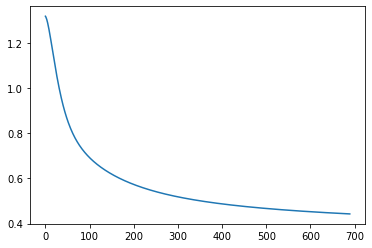

In [19]:
# Evolución de la pérdida (loss) en cada iteración del entrenamiento
plt.plot(modelo_rn.loss_curve_)
plt.show()

In [20]:
# Número de iteraciones en las que ha finalizado el entrenamiento
# Si se han alcanzado 'n_iter_no_change' sin que varíe la pérdida un valor mayor de 'tol'
modelo_rn.n_iter_

690

In [21]:
# Función de activación de la capa de salida de la red neuronal
modelo_rn.out_activation_

'softmax'

In [22]:
# Parámetros del modelo seleccionado
modelo_rn.get_params(deep=True)

{'activation': 'tanh',
 'alpha': 0.1,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (32, 16),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1234,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

---

# 3. Evaluar el modelo

In [23]:
# Se lleva a cabo la predicción para evaluar el modelo
y_pred = modelo_rn.predict(X_test_norm)

In [24]:
# Visualización de las predicciones
print(y_pred)

[1 1 1 0 1 0 0 2 1 1 1 0 2 1 0 1 0 0 2 0 0 1 1 1]


## Matriz de confusión

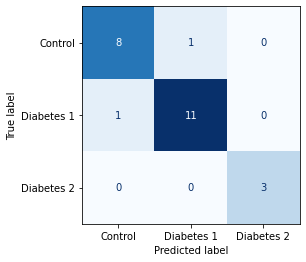

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
# Filas: valores reales
# Columnas: predicción

clases = ['Control', 'Diabetes 1', 'Diabetes 2']

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

disp.plot(cmap='Blues', colorbar=False)
plt.show()

## Classification report

In [26]:
clases = ['Control', 'Diabetes 1', 'Diabetes 2']

print(classification_report(y_test, y_pred, target_names=clases, digits=4))

              precision    recall  f1-score   support

     Control     0.8889    0.8889    0.8889         9
  Diabetes 1     0.9167    0.9167    0.9167        12
  Diabetes 2     1.0000    1.0000    1.0000         3

    accuracy                         0.9167        24
   macro avg     0.9352    0.9352    0.9352        24
weighted avg     0.9167    0.9167    0.9167        24

